<a href="https://colab.research.google.com/github/ysedurepo/deep_learning/blob/main/CNN_transfert_learning_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

## Kaggle Setting

In [2]:
!pip install -q kaggle


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"youssadi","key":"0979bdec5532397985cac13b4592724c"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
#Download the dataset and unzip it
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set

In [6]:
#Specify the training and test image folders
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

## Dataset

In [7]:
#The dataset
#we are fetching only the first 500 images from each folder
class CatsDogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    self.normalize = transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])
    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return (im.float().to(device),torch.tensor([target]).float().to(device))


tensor([1.], device='cuda:0')


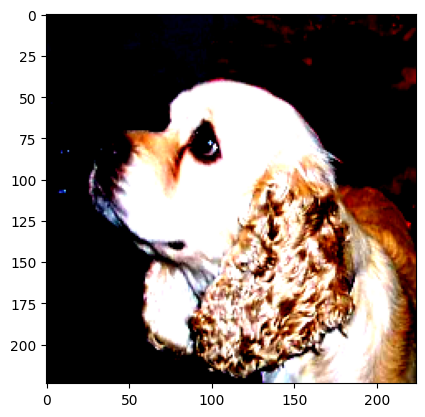

In [9]:
#Fetch the images and their labels:
data = CatsDogs(train_data_dir)
im, label = data[300]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

## The Model

In [16]:
#Download the pretrained VGG16 weights and then freeze the features module and train using
#the avgpool and classifier modules
def get_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  """Replace the avgpool module to return a feature map of size 1 x 1 instead of 7 x 7; in
other words, the output is now going to be batch_size x 512 x 1 x 1:"""
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  """ The classifier """
  model.classifier = nn.Sequential(nn.Flatten(),nn.Linear(512, 128),nn.ReLU(),nn.Dropout(0.2),nn.Linear(128, 1),nn.Sigmoid())
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)
  return model.to(device), loss_fn, optimizer

In [17]:
#The model summary
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

## Training

In [18]:
#Train on a batch of data:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [19]:
#Define a function to calculate accuracy on a batch of data:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  is_correct = (prediction > 0.5) == y
  return is_correct.cpu().numpy().tolist()

In [22]:
#Data Loader
def get_data():
  train = CatsDogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
  val = CatsDogs(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
  return trn_dl, val_dl

In [23]:
#Initialize the get_data and get_model functions:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
#Training Loop
def train():
  train_losses, train_accuracies = [], []
  val_accuracies = []
  for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
      x, y = batch
      batch_loss = train_batch(x, y, model, optimizer, loss_fn)
      train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
      x, y = batch
      is_correct = accuracy(x, y, model)
      train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
      x, y = batch
      val_is_correct = accuracy(x, y, model)
      val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    print(f"train loss: {train_epoch_loss:.6f} train accuracy: {train_epoch_accuracy:.6f} val accuracy: {val_epoch_accuracy:.6f}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
  return train_losses, train_accuracies, val_accuracies

In [37]:
train_losses, train_accuracies, val_accuracies = train()

 epoch 1/5
train loss: 0.009143 train accuracy: 1.000000 val accuracy: 0.980847
 epoch 2/5
train loss: 0.007031 train accuracy: 1.000000 val accuracy: 0.981855
 epoch 3/5
train loss: 0.006960 train accuracy: 1.000000 val accuracy: 0.981855
 epoch 4/5
train loss: 0.005402 train accuracy: 1.000000 val accuracy: 0.981855
 epoch 5/5
train loss: 0.005260 train accuracy: 1.000000 val accuracy: 0.981855


In [44]:
#Plot the training and test accuracy values over increasing epochs:
def plot_accuracies(train_accuracies, val_accuracies, name_model, epochs):
  import matplotlib.ticker as mtick
  import matplotlib.pyplot as plt
  import matplotlib.ticker as mticker
  %matplotlib inline
  plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracies, 'r',
  label='Validation accuracy')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.title('Training and validation accuracy with' + name_model + '\nand 1K training data points')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(0.95,1)
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
  plt.legend()
  plt.grid('off')
  plt.show()

In [ ]:
epochs = np.arange(5)+1
plot_accuracies(train_accuracies, val_accuracies, 'VGG16' , epochs)

#The ResNet Architecture


In [26]:
#ResNet Block
class ResLayer(nn.Module):
  def __init__(self,ni,no,kernel_size,stride=1):
    super(ResLayer, self).__init__()
    padding = kernel_size - 2
    self.conv = nn.Sequential(nn.Conv2d(ni, no, kernel_size, stride,padding=padding),nn.ReLU())
  def forward(self, x):
    x = self.conv(x) + x
    return x

## The resnet Model ResNet18
The structure of the ResNet18 model contains the following components:
• Convolution
• Batch normalization
• ReLU
• MaxPooling
• Four layers of ResNet blocks
• Average pooling (avgpool)
• A fully connected layer (fc)

In [40]:
def get_model():
  model = models.resnet18(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.fc = nn.Sequential(nn.Flatten(),nn.Linear(512, 128),nn.ReLU(),nn.Dropout(0.2),nn.Linear(128, 1),nn.Sigmoid())
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3)
  return model.to(device), loss_fn, optimizer

In [41]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [42]:
train_losses, train_accuracies, val_accuracies = train()

 epoch 1/5
train loss: 0.332036 train accuracy: 0.964718 val accuracy: 0.964718
 epoch 2/5
train loss: 0.134204 train accuracy: 0.966734 val accuracy: 0.969758
 epoch 3/5
train loss: 0.109040 train accuracy: 0.981855 val accuracy: 0.973790
 epoch 4/5
train loss: 0.078591 train accuracy: 0.988911 val accuracy: 0.973790
 epoch 5/5
train loss: 0.084839 train accuracy: 0.986895 val accuracy: 0.965726


<ipython-input-44-df74e7099f6d>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


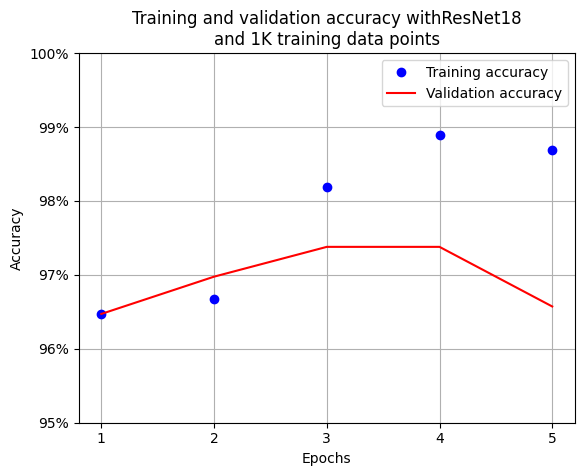

In [45]:
epochs = np.arange(5)+1
plot_accuracies(train_accuracies, val_accuracies, 'ResNet18', epochs)